<img src="../../qiskit-iqx-tutorials/images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

## Randomized Benchmarking
---

* **Requires:** qiskit-terra 0.8, qiskit-ignis 0.1.1, qiskit-aer 0.2


## Introduction

**Randomization benchmarking (RB)** is a well-known technique to measure average gate performance by running sequences of random Clifford gates that should return the qubits to the initial state. 
Qiskit Ignis has tools to generate one- and two-qubit Clifford gate sequences simultaneously. 

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module. This particular example shows how to run 2-qubit randomized benchmarking (RB) . There are also examples on how to use some of the companion functions for predicting RB fidelity.

In [1]:
# -*- coding: utf-8 -*-

# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.


#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import os, sys
HOME = "/home/jolea/anaconda3/git/qiskit-ignis/"
QISKIT_ROOT = HOME
root_dir = os.path.expanduser(QISKIT_ROOT)
sys.path = [os.path.expanduser(QISKIT_ROOT)] + sys.path

#from qiskit1.ignis.verification.randomized_benchmarking \
#    import PauliUtils as plutils

#Import the RB Functions
import qiskit1.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes 
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error


## Select the Parameters of the RB Run

First, wee need to choose the following parameters:

- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **group_gates:** the name of the group


## Generate RB sequences

We generate RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_circs:** A list of lists of circuits for the RB sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).
- **rb_opts_dict:** Option dictionary back out with default options appended.

In this example we have 2 qubits Q0,Q1. 
We are running 2Q RB (on qubits Q0,Q1) 


In [2]:
#______________________________________________________________________________________

#Generate RB circuits (2Q RB)

#number of qubits
nQ=2 
rb_opts = {}
#Number of Paulis in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
#Number of seeds (random sequences)
rb_opts['nseeds'] = 5 
#Default pattern
rb_opts['rb_pattern'] = [[0,1]]
rb_opts['group_gates'] = 'Pauli'

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

As an example, we print the circuit corresponding to the first RB sequence:


In [3]:
#______________________________________________________________________________________

print(rb_circs[0][0])

#______________________________________________________________________________________


         ┌───┐ ░ ┌───┐┌─┐
qr_0: |0>┤ Z ├─░─┤ Z ├┤M├
         └───┘ ░ └┬─┬┘└╥┘
qr_1: |0>──────░──┤M├──╫─
               ░  └╥┘  ║ 
 cr_0: 0 ══════════╬═══╩═
                   ║     
 cr_1: 0 ══════════╩═════
                         


## Look at the Unitary for 1 Circuit
The Unitary representing each RB circuit should be the identity (with a global phase),
since we multiply random CNOTpauli elements, including a computed reversal gate. We simulate this using an Aer unitary simulator.

In [4]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)
	
#______________________________________________________________________________________


In [5]:
# The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
print(np.around(job.result().get_unitary(),3))

#______________________________________________________________________________________


[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


## Define the noise model
We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [6]:
# Run on a noisy simulator
noise_model = NoiseModel()
# Depolarizing_error
dp = 0.005 
noise_model.add_all_qubit_quantum_error(depolarizing_error(dp, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*dp, 2), 'cx')

backend = qiskit.Aer.get_backend('qasm_simulator')
#______________________________________________________________________________________


## Execute on Aer simulator

We can execute the RB sequences either using a Qiskit Aer Simulator (with some noise model) or using an IBMQ provider, 
and obtain a list of results, `result_list`.

In [7]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
qobj_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    qobj_list.append(qobj)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

#______________________________________________________________________________________


Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.995701, EPC: 0.003224
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.994809, EPC: 0.003893
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.993756, EPC: 0.004683
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.992296, EPC: 0.005778
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.992613, EPC: 0.005540


### Plot the results

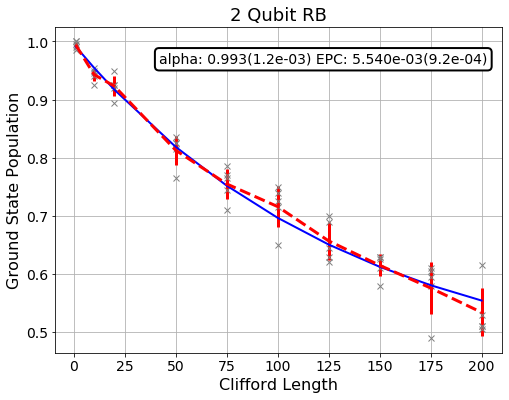

In [8]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()


#______________________________________________________________________________________


### Predicted Gate Fidelity
From the known depolarizing errors on the simulation we can predict the **fidelity**. 
First we need to count the number of **gates per CNOTPauli**.

The function **gates_per_clifford** takes a compiled qobj and outputs the number of basis gates in each circuit.

In [9]:
#Count the number of single and 2Q gates in the 2Q Pauli
gates_per_cliff = rb.rb_utils.gates_per_clifford(qobj_list, xdata[0],basis_gates, rb_opts['rb_pattern'][0])
for i in range(len(basis_gates)):
    print("Number of %s gates per Pauli: %f"%(basis_gates[i],
                                                 np.mean([gates_per_cliff[0][i],gates_per_cliff[1][i]])))
#______________________________________________________________________________________


Number of u1 gates per Pauli: 0.257969
Number of u2 gates per Pauli: 0.000000
Number of u3 gates per Pauli: 0.513537
Number of cx gates per Pauli: 0.000000
